# Regresión Logística
### Daniel Marín López

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_digits
import sklearn
import sklearn.metrics as Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

In [2]:
TEST = 0.2
SEED = 42

### Ejercicio 1
Construye un modelo de Regresión Logística que prediga la probabilidad de supervivencia de los pasajeros del Titanic, utilizando el dataset disponible en seaborn o en Kaggle. Ten en cuenta que tienes que hacer un preprocesamiento previo de los datos y que hay variables categóricas. Además del modelo tienes que proporcionar la matriz de confusión y el informe de clasificación.

#### Introducción

Usaremos el `titanic.csv` de seaborn y además seguiré un poco el tutorial de [Logistic Regression (Titanic Dataset)](https://www.kaggle.com/code/mohamedhanyyy/logistic-regression-titanic-dataset) como guía sobre todo para el tratamiento de los datos.

In [3]:
!wget https://raw.githubusercontent.com/mwaskom/seaborn-data/master/titanic.csv

--2025-03-29 10:04:00--  https://raw.githubusercontent.com/mwaskom/seaborn-data/master/titanic.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57018 (56K) [text/plain]
Saving to: ‘titanic.csv’

titanic.csv         100%[===================>]  55.68K  --.-KB/s    in 0.004s  

2025-03-29 10:04:01 (12.7 MB/s) - ‘titanic.csv’ saved [57018/57018]



In [4]:
titanic_data = pd.read_csv('titanic.csv')
titanic_data.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


Revisamos las características de nuestro dataset:

In [5]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


Podemos ver que tiene los siguientes problemas:

* Hay valores nulos
* Hay valores categóricos

Intentemos contar los valores nulos.

In [6]:
print(titanic_data.isnull().sum())

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64


Observamos que la categoría `deck` prácticamente está casi vacía. Visualicemos el objetivo de nuestro dataset.

In [7]:
def visualize_target(data, target):
  plt.figure(figsize=(10, 5))
  plt.xlabel(target)
  plt.ylabel('Count')
  ax = sns.countplot(x=target, data=data)

  # Add count labels to the bars
  for p in ax.patches:
      ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='center', xytext=(0, -10), textcoords='offset points')

  plt.show()

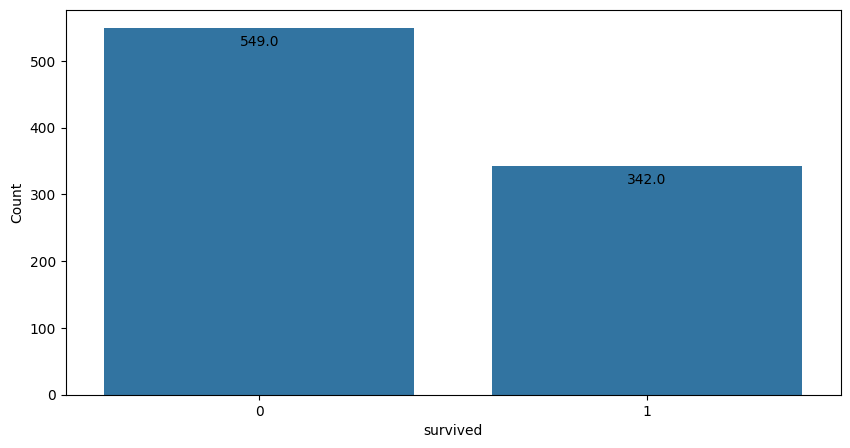

In [8]:
visualize_target(titanic_data, 'survived')

Vemos que tenemos más personas que no han sobrevivido que las que sí. Empecemos con el tratameinto de los datos.

#### Preprocesamiento

Tenemos que encargarnos de los siguiente problemas:

* Valores faltantes o nulos
* Valores categóricos

#### Valores faltantes

Empezando con los valores faltantes podemos ver que hay lo siguiente:

* `age`: Falta un 20%.
* `deck`: Falta más de un 80%. Posiblemente se elimine porque no nos va aportar nada. Si miramos la edad:

<Axes: >

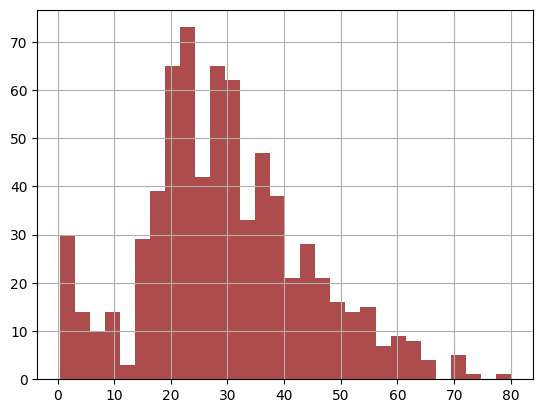

In [9]:
titanic_data['age'].hist(bins=30,color='darkred',alpha=0.7)

Vemos que más o menos sigue una distribución normal. Se podría usar la mediana para completar los datos, pero intentaremos la solución propuesta en el tutorial que nos dice que puede haber otra característica que pueda darnos información sobre la posible edad de los pasajeros (como la clase en la que viajaban).

<Axes: xlabel='pclass', ylabel='age'>

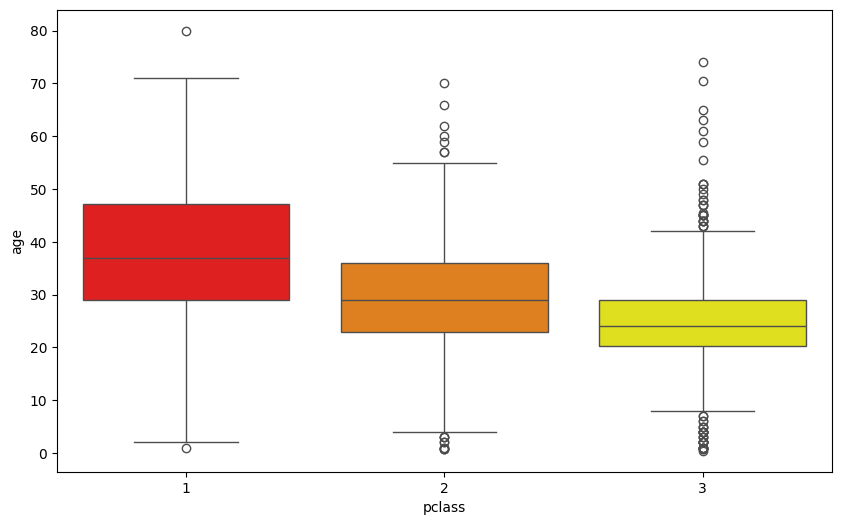

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='pclass',y='age',data=titanic_data,hue='pclass',palette='autumn',legend=False)

Vemos que, efectivamente, hay una relación:

* Los pasajeros en **primera clase** suelen estar en torno a los **40 años**.
* Los pasajeros en **segunda clase** suelen estar en torno a los **30 años**.
* Por último, los pasajeros en **tercera clase** suelen estar en torno a los 25 años.

Es decir, a **más edad** ⟹ **mejor será la clase**.

Podemos estimar la edad en base a la clase que viajan los pasajeros, podemos realizarlo con el siguiente código:

In [11]:
def fill_age(cols):
  Age = cols.iloc[0]
  Pclass = cols.iloc[1]

  if pd.isnull(Age):
    if Pclass == 1:
      return 37

    elif Pclass == 2:
      return 29

    else:
      return 24

  else:
    return Age

Una vez está definida la función, realizamos el tratamiento de la columna `Age`.

In [12]:
titanic_data['age'] = titanic_data[['age','pclass']].apply(fill_age,axis=1)

Revisamos si los valores faltantes en la edad ya no están.

In [14]:
print(titanic_data.isnull().sum())

survived         0
pclass           0
sex              0
age              0
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64


Vemos que se han completado los valores con éxito. Por último, eliminamos la columna `deck` y otros pocos perdidos en alguna que otra característica.

In [15]:
titanic_data.drop('deck',axis=1,inplace=True)
titanic_data.dropna(inplace=True)

Revisemos como están los datos en este momento.

In [16]:
titanic_data.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,Southampton,no,True


#### Valores categóricos

Lo siguiente será tratar los valores categóricos, revisando las categorías encontramos los siguientes valores categóricos:

* `sex`
* `class`
* `who`
* `embarked`
* `embarked_town`
* `alive`

De aquí vemos que `class`, `embarked_town` y `who` muy probablemente sean eliminados ya que son valores repetidos, la columna `alive` es el objetivo por lo que será eliminada obligatoriamente. Por lo que, solamente trataremos las columnas `Sex` y `Embarked`. Para ello, usaremos `pd.get_dummies` para pasar los valores categóricos a numéricos.

In [17]:
sex = pd.get_dummies(titanic_data['sex'],drop_first=True)
embark = pd.get_dummies(titanic_data['embarked'],drop_first=True)

Ahora borramos todas las columnas categóricas e introducimos los numéricos.

In [18]:
titanic_data.drop(['sex','embarked','who','class','embark_town','class','alive'],axis=1,inplace=True)
titanic_data = pd.concat([titanic_data,sex,embark],axis=1)

Revisamos los datos de nuevo.

In [19]:
titanic_data.head()

,survived,pclass,age,sibsp,parch,fare,adult_male,alone,male,Q,S
0,0,3,22.0,1,0,7.2500,True,False,True,False,True
1,1,1,38.0,1,0,71.2833,False,False,False,False,False
2,1,3,26.0,0,0,7.9250,False,True,False,False,True
3,1,1,35.0,1,0,53.1000,False,False,False,False,True
4,0,3,35.0,0,0,8.0500,True,True,True,False,True


Vemos que ha salido todo bien, se han agregado tres columnas nuevas:

* `male`: Indica si el pasajero es hombre o no.
* `Q`: Indica si el pasajero embarcó en Queenstown (`Q`).
* `S`: Indica si el pasajero embarcó en Southampton (`S`).

Realizamos una matriz de correlación ahora que nuestros valores son númericos:

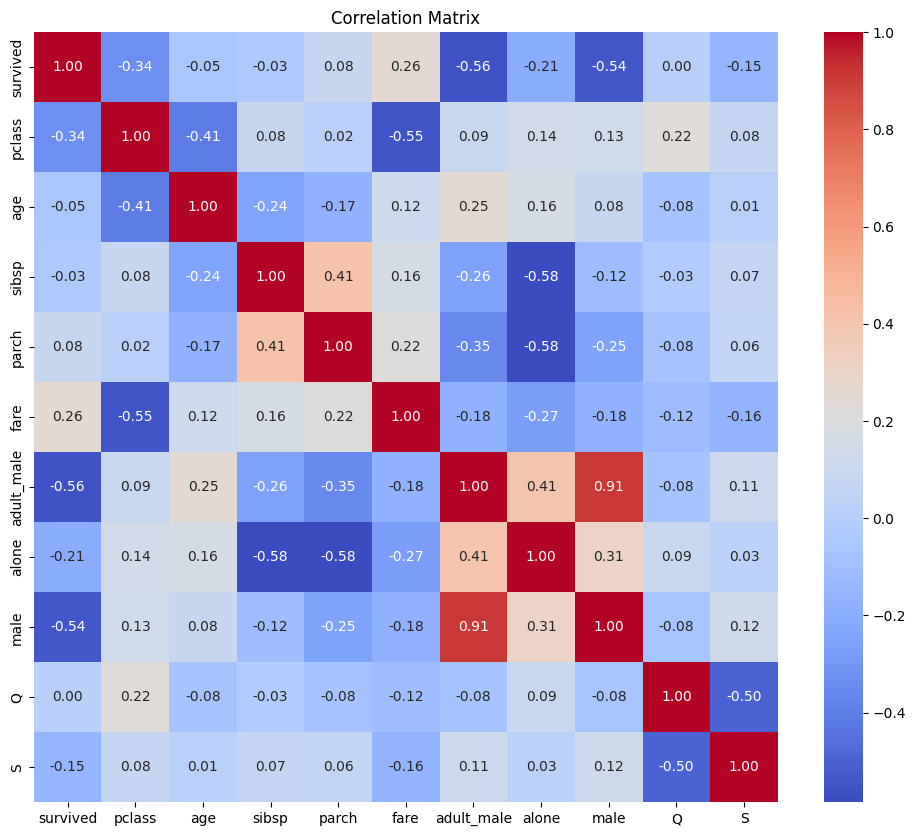

In [ ]:
# Calculate the correlation matrix
correlation_matrix = titanic_data.corr()

# You can also visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


Vemos que no hay mucha correlación entre las características y el objetivo, las más altas están relacionadas con el sexo de los pasajeros.

#### Balanceo

Una vez tenemos nuestro dataset solo numérico, podemos intentar balancear nuestro dataset para no favorecer a una clase concreta. Antes de hacer nada, haremos nuestros datos de entrenamiento y prueba para que no haya fuga de datos.

In [ ]:
X = titanic_data.drop('survived',axis=1)
y = titanic_data['survived']

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X, y, test_size=TEST, random_state=SEED)

Revisamos como está nuestro objetivo:

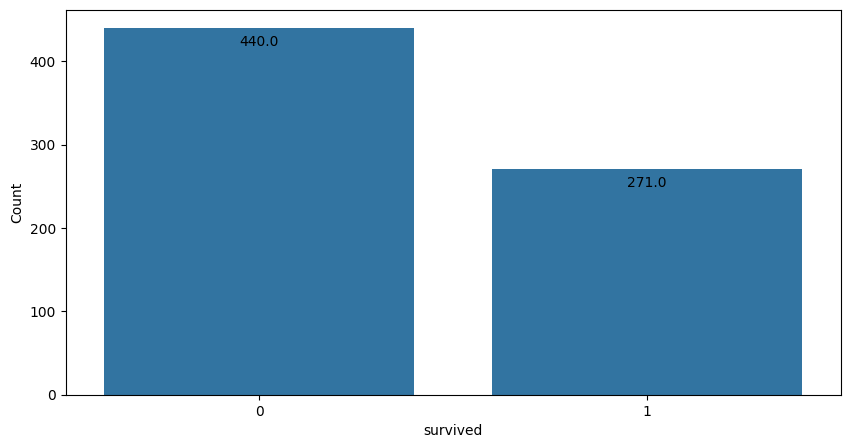

In [ ]:
visualize_target(pd.concat([X_train_t, y_train_t], axis=1), 'survived')

Efectivamente tenemos casi el doble de las personas que murieron que las que vivieron. Es por ello que intentaremos incrementar el número de personas vivas. Con la función `balance_dataset` aplicaremos `SMOTE` sobre nuestros datos para balancear las clases.

In [ ]:
def balance_dataset(X_train, y_train):
  sm = SMOTE(random_state=SEED)
  X_train_balanced, y_train_balanced = sm.fit_resample(X_train, y_train)

  return X_train_balanced, y_train_balanced

In [ ]:
X_train_balanced, y_train_balanced = balance_dataset(X_train_t, y_train_t)

Revisamos el resultado:

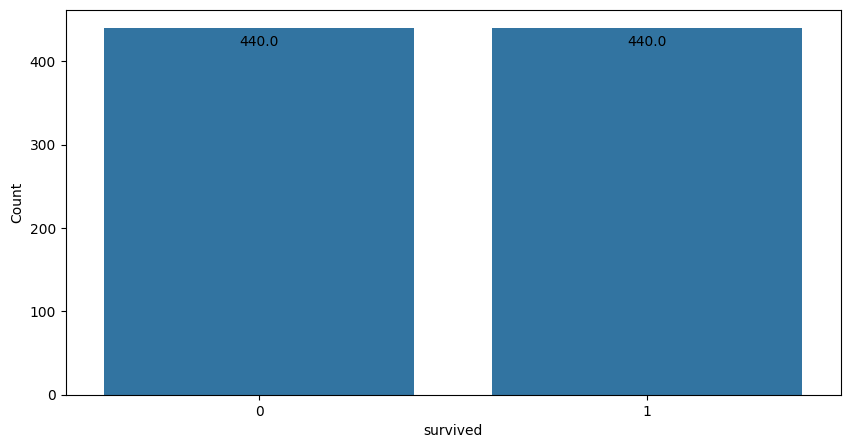

In [ ]:
visualize_target(pd.concat([X_train_balanced, y_train_balanced], axis=1), 'survived')

Podemos ver que ya nuestro dataset está balanceado.

#### Escalado

Por último, haremos un escalado de los datos. Esto ya es mucho más sencillo con los datos solo numéricos, usaremos `StandardScaler` que es más resistentes a los outliers.

In [ ]:
titanic_std = StandardScaler()
X_train_std = titanic_std.fit_transform(X_train_balanced)
X_test_std = titanic_std.transform(X_test_t)

#### Creación del modelo
Una vez tenemos nuestro datos escalados, ya podemos empezar a buscar los mejores hiperparámetros para nuestro modelo.

In [ ]:
param_random = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

lg_random = GridSearchCV(LogisticRegression(), param_random, cv=5)
lg_random.fit(X_train_std, y_train_balanced)
print(lg_random.best_params_)

{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


Hemos obtenido los siguientes hiperparámetros:

* `C`: 0.1
* `penalty`: `l1`
* `solver`: `liblinear` (Solo podemos usar este para una salida binaria).

Creamos el modelo con estos hiperparámetros:

In [ ]:
titanic_model = LogisticRegression(C=0.1, penalty='l1', solver='liblinear')
titanic_model.fit(X_train_std, y_train_balanced)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

#### Resultados

Una vez hemos creado nuestro modelo, miramos el desempeño que tiene.

In [ ]:
y_predict_t = titanic_model.predict(X_test_std)

print(Metrics.classification_report(y_test_t, y_predict_t))

              precision    recall  f1-score   support

           0       0.88      0.76      0.82       109
           1       0.69      0.84      0.76        69

    accuracy                           0.79       178
   macro avg       0.79      0.80      0.79       178
weighted avg       0.81      0.79      0.79       178



In [ ]:
titanic_model.score(X_test_std, y_test_t)

0.7921348314606742

Vemos que tanto el desempeño como la score obtenida ronda en torno al 79%. Lo que nos indica que es muy buen modelo, ahora revisaremos la matriz de confusión.

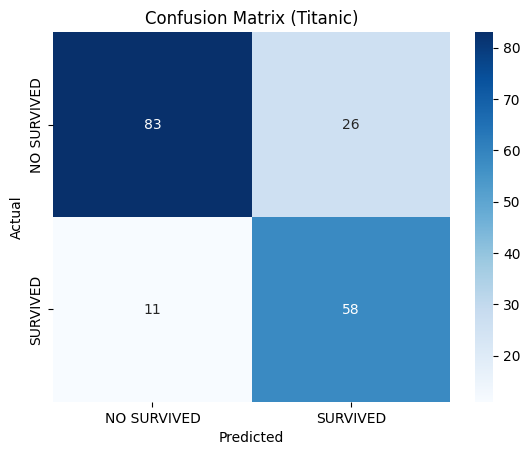

In [ ]:
titanic_cm = Metrics.confusion_matrix(y_test_t, y_predict_t)
CLASSES = ['NO SURVIVED', 'SURVIVED']
sns.heatmap(titanic_cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Titanic)')
plt.show()

Vemos que la matriz de confusión ha salido bastante bien, lo que indica que es un buen modelo.

---

### Ejercicio 2
Construye un modelo de Regresión Logística que sea capaz de reconocer dígitos escritos a mano (0-9) utilizando el dataset digits de Scikit-Learn. Ten en cuenta que cada imagen es de 8x8 píxeles, tiene una etiqueta (0-9) indicando el dígito correspondiente y que no es un problema de clasificación binaria.

Cargamos los datos.

In [ ]:
digits = load_digits()

pd_digits = pd.DataFrame(digits.data)
pd_digits['target'] = digits.target
pd_digits.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


Miramos las dimensiones de nuestros datos.

In [ ]:
digits.data.shape

(1797, 64)

Nos da un total de 1797 filas y 64 columnas, lo cual es normal ya que las columnas en este caso representan las imágenes de los distintos dígitos.

In [ ]:
digits.target.shape

(1797,)

Lo siguiente que haremos será intentar visualizar los primeros digitos de nuestro dataset podemos hacer el siguiente código:

Un bucle donde va agregando a la gráfica un nuevo dígito en un tamaño de 8x8 píxeles y en escala de grises.

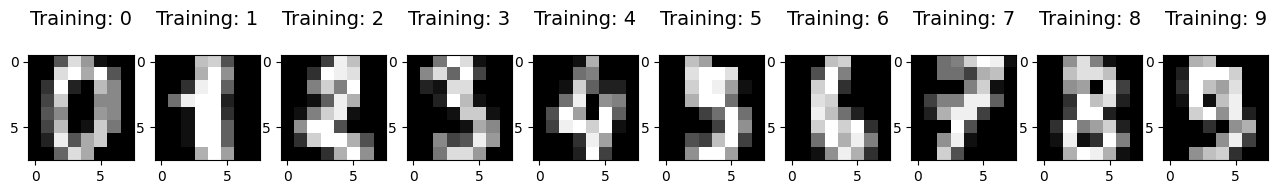

In [ ]:
plt.figure(figsize=(16,9))
for index, (image, label) in enumerate(zip(digits.data[0:10],digits.target[0:10])):
    plt.subplot(1,10, index + 1)
    plt.imshow(np.reshape(image, (8,8)), cmap = plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 14)

Vemos que algunos dígitos como el 0 o el 7 son fáciles de entender mientras que otros como el 5 o 6 son más difíciles de entender.

Hacemos la separación entre entrenamiento y test.

In [ ]:
x_train_d, x_test_d, y_train_d, y_test_d = train_test_split(digits.data, digits.target,
                                                    test_size=TEST, random_state=SEED)

Escalamos los datos:

In [ ]:
digits_std = StandardScaler()
x_train_d = digits_std.fit_transform(x_train_d)
x_test_d = digits_std.transform(x_test_d)

Ahora creamos los distintos modelos para cada dígito con el método **uno contra todos**. Para ello haremos los siguientes pasos:

* Recorreremos un rango de 10 (0-9) y crearemos una clase binaria en donde si el dígito es el del índice del bucle será 1 (Verdadero) y el resto 0 (Falso).
* Después, creamos el modelo y lo entrenamos con esta clase binaria y lo guardamos en la lista de modelos.

In [ ]:
# Creamos un modelo de regresión logística para cada dígito (uno contra todos)
models = []

for digit in range(10):
  # Sacamos la y binaria, si coincide con el dígito es 1 y el resto es 0
  y_train_digit = (y_train_d == digit).astype(int)

  # Creamos un modelo de regresión logística
  model = LogisticRegression(max_iter=1000)

  # Ajustamos el modelo con las muestras donde el target es el dígito
  model.fit(x_train_d, y_train_digit)
  models.append(model)

Para sacar las predicciones recorreremos cada modelo y usaremos `predict_proba` para sacar las probabilidades de cada dígito para cada imagen. Luego trasponemos la matriz y usamos `argmax` para encontrar el dígito con la probabilidad más alta y asignar su predicción para ese dígito concreto.

In [ ]:
# Predecimos las probabilidades para cada dígito
y_pred_probs = []
for model in models:
    y_pred_probs.append(model.predict_proba(x_test_d)[:, 1])

# Calculamos las predicciones y transponemos el array
# para que sus valores sean más fáciles
y_pred_probs = np.array(y_pred_probs).transpose()
y_pred = np.argmax(y_pred_probs, axis=1)

Por último, evaluamos el modelo.

In [ ]:
# Evaluamos el modelo
accuracy = Metrics.accuracy_score(y_test_d, y_pred)
print("Accuracy:", accuracy)
print("="*35)
# Podemos mostrar el reporte de clasificación
print(Metrics.classification_report(y_test_d, y_pred))

Accuracy: 0.9666666666666667
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       0.93      1.00      0.97        28
           2       1.00      1.00      1.00        33
           3       1.00      0.97      0.99        34
           4       1.00      0.98      0.99        46
           5       0.92      0.94      0.93        47
           6       0.97      0.97      0.97        35
           7       1.00      0.97      0.99        34
           8       0.93      0.93      0.93        30
           9       0.93      0.93      0.93        40

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360



Vemos que el desempeño del modelo es de un 97%, algo muy bueno. Visualizamos la matriz de confusión:

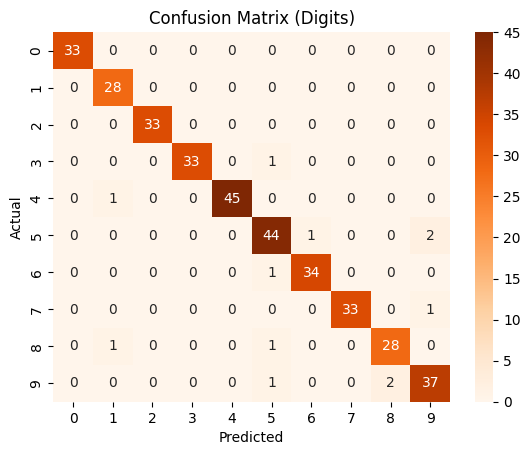

In [ ]:
digits_cm = Metrics.confusion_matrix(y_test_d, y_pred)
CLASSES = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
sns.heatmap(digits_cm, annot=True, fmt='d', cmap='Oranges', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Digits)')
plt.show()

Vemos que los resultados son bastantes buenos, fallando muy poco o casi nada.